In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import scipy.linalg as la
from matplotlib import pyplot as plt
from autograd import elementwise_grad
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Exercise 9.22

In [2]:
def forward_euler_1D_heat(b, CFL,T,x=[],u0=[]):
    """solution of the 1D heat equation u_t=u_xx.
        u_x(0) = a, and u(1) = b are the BCs
        CFL=deltaT/(deltaX^2)
        T is the final time that the simulation will be run
        x is the pre-selected spatial variable,
        and should be uniformly distributed
        u0 is the initial condition, and must be the same size as x

        Returns an array u which is the solution at all
        time steps up to T
        as dictated by the time-step chosen through the
        specified 'CFL'number.
    """
    N = len(x)
    deltaX = 1/(N-1)
    deltaT = CFL*(deltaX)**2
    u = []
    u.append(u0)
    v = u0.copy() #a dummy variable for the update process
    for nn in range(1,int(T/deltaT)):
        # double check that the BCs are maintained
        v[-1] = b
        v[0] = u[nn-1][0] + 2*CFL*(u[nn-1][1] - u[nn-1][0])
        for jj in range(1,N-1):
            #here is where we make our update
            v[jj] = u[nn-1][jj] + CFL*(u[nn-1][jj-1]-2*u[nn-1][jj]+u[nn-1][jj+1])
        u.append(v.copy())
    return x,np.array(u), deltaT

In [3]:
def problem9_22_vals():
    initial_cond = lambda x: x**2*np.sin(2*np.pi*x)
    b = 0
    x_vals = np.linspace(0, 1, 60)
    CFL = 1/2
    T = 3
    u0 = initial_cond(x_vals)
    x, u, deltaT = forward_euler_1D_heat(b, CFL, T, x_vals, u0)

    return x, u, deltaT
x, u, deltaT = problem9_22_vals()

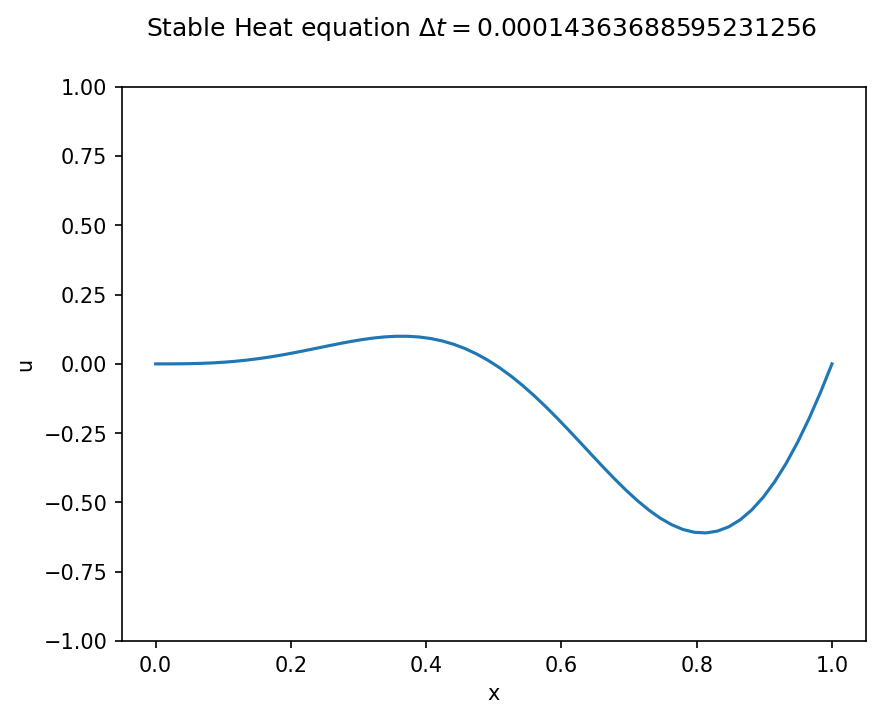

In [4]:
#creae animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)
ax.set_xlim(0, 1)
plt.suptitle(r'Stable Heat equation $\Delta t = $' + str(deltaT))
#update function
def update1(i):
    ax.clear()
    ax.set_ylim(-1, 1)
    ax.plot(x, u[i])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    return ax

ani = animation.FuncAnimation(fig, update1,
                              frames = range(500), 
                              interval=20)
HTML(ani.to_html5_video())

We used a 60 element grid in the spatial discretizaton with a CFL of $1/2$ this gave a time step of $\Delta t = 0.00014$ 

# Exercise 9.23

In [5]:
def backward_euler_1D_heat_array(CFL,T,x=[],u0=[]):
    """solution of the 1D heat equation u_t=u_xx.
    u(0) = 0, and u(1) = 0 are the BCs
    CFL=deltaT/(deltaX^2)
    T is the final time that the simulation will be run
    x is the pre-selected spatial variable, and should be 
    uniformly distributed
    u0 is the initial condition, and must be the same size as x0
    Returns an array u which is the solution at all time steps up to T
    as dictated by the time-step chosen through the specified 'CFL' number.
    """
    N = len(x)
    deltaX = 1/(N-1)
    deltaT = CFL*(deltaX)**2
    u = []
    u.append(u0)
    v = u0.copy() #a dummy variable for the update process
    A = np.diag(np.ones(N-3),-1)-2*np.diag(np.ones(N-2),0)+np.diag(np.ones(N-3),1)
    B = linalg.inv((np.eye(N-2)-CFL*A))
    for nn in range(1,int(T/deltaT)):
        # double check that the BCs are maintained
        v[0] = 0
        v[-1] = 0
        v[1:-1] = np.matmul(B,u[nn-1][1:-1])
        u.append(v.copy())
    return x,u, deltaT

In [6]:
def problem9_23_vals():
    initial_cond = lambda x: np.sin(2*np.pi*x)
    b = 0
    x_vals = np.linspace(0, 1, 25)
    CFL = 3/4
    T = 3
    u0 = initial_cond(x_vals)
    x, u, deltaT = backward_euler_1D_heat_array(CFL, T, x_vals, u0)

    return x, u, deltaT

x, u, deltaT = problem9_23_vals()
#creae animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)
ax.set_xlim(0, 1)
plt.suptitle(r'Heat equation backward Euler $\Delta t = $' + str(deltaT))
#update function
def update1(i):
    ax.clear()
    ax.set_ylim(-1, 1)
    ax.plot(x, u[i])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    return ax

ani = animation.FuncAnimation(fig, update1,
                              frames = range(500), 
                              interval=35)
HTML(ani.to_html5_video())

To get $\Delta t$ to be 10 times larger with the backward Euler method we let $CFL = 3/4$ and the spatial discretization was with 25 points. This gave $\Delta t = 0.0013$.

# Exercise 9.24

In [7]:
#Crank Nickelson
def heat_cn(x0, xf, t0, tf, nu, uL, uR, f, I=50, J=50):
    ''' Numerically solves the head equation using
        the Crank Nicolson method.
        Parameters:
            :param x0: float, defines the left spatial endpoint
            :param xf: float, defines the right spatial endpoint
            :param t0: float, starting time
            :param tf: float, final time
            :param nu: float, diffusion constant
            :param uL: callable, left boundary condition
            :param uR: callable, right boundary condition
            :param f: callable, initial value for x
            :param J: int, spatial discretization
            :param M: int, temporal discretization
        :return:
            x_vals ((J+1, ), discretized values)
            U ((M+1, J+1), np.ndarray)
    '''
    #get spatial and temporal discritezation
    #as well as well as stepping values
    x_vals = np.linspace(x0, xf, I+1)
    t_vals = np.linspace(t0, tf, J+1)
    h = np.abs(x_vals[-1] - x_vals[-2])
    k = np.abs(t_vals[-1] - t_vals[-2])
    lam = nu*k/(2*h**2)

    #construct A matrix
    #main diagonal
    A_diag = (1-2*lam)*np.ones(I+1)
    A_diag[0] = 1
    A_diag[-1] = 1
    A_diag = np.diag(A_diag, k=0)
    #super diagonal
    A__sup_diag = lam*np.ones(I)
    A__sup_diag[0] = 0
    A_sup_diag = np.diag(A__sup_diag, k=1)
    #sub diagonal
    A_sub_diag = A__sup_diag
    A_sub_diag[0] = lam
    A_sub_diag[-1] = 0
    A_sub_diag = np.diag(A_sub_diag, k=-1)
    A = A_sub_diag + A_sup_diag + A_diag

    #construct B matrix
    #main diagonal
    B_diag = (1 + 2*lam)*np.ones(I+1)
    B_diag[0] = 1
    B_diag[-1] = 1
    B_diag = np.diag(B_diag, k=0)
    #super diagonal
    B__sup_diag = -lam*np.ones(I)
    B__sup_diag[0] = 0
    B_sup_diag = np.diag(B__sup_diag, k=1)
    #sub diagonal
    B_sub_diag = B__sup_diag
    B_sub_diag[0] = -lam
    B_sub_diag[-1] = 0
    B_sub_diag = np.diag(B_sub_diag, k=-1)
    B = B_sub_diag + B_sup_diag + B_diag
    #invert matrix and apply matrix multiplication now to save time
    C = la.inv(B)@A

    #now we can start our iterations
    U_0 = f(x_vals)
    U_1 = C@U_0
    U = np.vstack((U_0, U_1))
    for i in range(2, J+1):
        U_curr =  C@U[i-1]
        U = np.vstack((U, U_curr))

    #now we enforce our boundary conditions
    U[:, 0] = uL(t_vals)
    U[:, -1] = uR(t_vals)

    return x_vals, U, k

def problem9_24_vals():
    x0, xf, t0, tf, nu = 0, 1, 0, 3, 1
    uL = lambda t: t*0.0
    uR = lambda t: t*0.0
    f = lambda x: np.sin(2*np.pi*x)
    
    x1, u1, deltaT1 = heat_cn(x0, xf, t0, tf, nu, uL, uR, f, I=100, J=500)
    f = lambda x: x**2*np.sin(2*np.pi*x)
    x2, u2, deltaT2 = heat_cn(x0, xf, t0, tf, nu, uL, uR, f, I=100, J=500)
    
    return x1, u1, deltaT1, x2, u2, deltaT2


x1, u1, deltaT1, x2, u2, deltaT2 = problem9_24_vals()

#create animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)
ax.set_xlim(0, 1)
title = r'Heat equation Crank-Nicolson $\Delta t = $' + str(round(deltaT1, 4)) + '\n$u(0, x) = \sin(2 \pi x)$'
plt.suptitle(title)
#update function
def update1(i):
    ax.clear()
    ax.set_ylim(-1, 1)
    ax.plot(x1, u1[i])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    return ax

ani = animation.FuncAnimation(fig, update1,
                              frames = range(20), 
                              interval=100)
HTML(ani.to_html5_video())

In [8]:
#create animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)
ax.set_xlim(0, 1)
title = r'Heat equation Crank-Nicolson $\Delta t = $' + str(round(deltaT2, 4)) + '\n$u(0, x) =x^2 \sin(2 \pi x)$'
plt.suptitle(title)
plt.suptitle(title)
#update function
def update1(i):
    ax.clear()
    ax.set_ylim(-1, 1)
    ax.plot(x2, u2[i])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    return ax

ani = animation.FuncAnimation(fig, update1,
                              frames = range(u2.shape[0]//10), 
                              interval=100)
HTML(ani.to_html5_video())